**Learning Objective**: Create a minimal set of features that performs just as well as a more complex feature set

## Setup

Load & prepare the California housing data.

In [37]:
from __future__ import print_function

import math 

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

from tensorflow.keras import optimizers
from functools import partial


# Original Codelab code had this line, but it is not compatible with TensorFlow 2
# tf.logging.set_verbosity(tf.logging.ERROR)
# Replaced with below
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

# Line below was missing - i.e. we did not reshuffle the data.
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index)
)

In [38]:
def preprocess_features(california_housing_dataframe):
    """Prepares input features from California housing data set.
    
    Args:
        california_housing_dataframe: A Pandas DataFrame expected to contain data
          from the California housing data set.
    Returns:
        A DataFrame that contains the features to be used for the model, including 
        synthetic features.
    """
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"
        ]]
    processed_features = selected_features.copy()
    # Create synthetic feature
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"]
    )
    
    
    processed_features["lat_to_33"] = np.where(california_housing_dataframe["latitude"] < 33, 1, 0)
    processed_features["lat_33_to_34"] = np.where((california_housing_dataframe["latitude"] >= 33)  & (california_housing_dataframe["latitude"] < 34), 1, 0)
    processed_features["lat_34_to_35"] = np.where((california_housing_dataframe["latitude"] >= 34)  & (california_housing_dataframe["latitude"] < 35), 1, 0)
    processed_features["lat_35_to_36"] = np.where((california_housing_dataframe["latitude"] >= 35)  & (california_housing_dataframe["latitude"] < 36), 1, 0)
    processed_features["lat_36_to_37"] = np.where((california_housing_dataframe["latitude"] >= 36)  & (california_housing_dataframe["latitude"] < 37), 1, 0)
    processed_features["lat_37_to_38"] = np.where((california_housing_dataframe["latitude"] >= 37)  & (california_housing_dataframe["latitude"] < 38), 1, 0)
    processed_features["lat_38_to_39"] = np.where((california_housing_dataframe["latitude"] >= 38)  & (california_housing_dataframe["latitude"] < 39), 1, 0)
    processed_features["lat_39_to_40"] = np.where((california_housing_dataframe["latitude"] >= 39)  & (california_housing_dataframe["latitude"] < 40), 1, 0)
    processed_features["lat_40_to_41"] = np.where((california_housing_dataframe["latitude"] >= 40)  & (california_housing_dataframe["latitude"] < 41), 1, 0)
    processed_features["lat_41_to_42"] = np.where((california_housing_dataframe["latitude"] >= 41)  & (california_housing_dataframe["latitude"] < 42), 1, 0)

    
    return processed_features

def preprocess_targets(california_housing_dataframe):
    """Prepares target features (i.e. labels) from California housing data set.
    
    Args:
        california_housing_dataframe: A Pandas DataFrame expected to contain data
            from the California housing data set.
    Returns
        A DataFrame that contains the target feature
    """
    output_targets = pd.DataFrame()
    
    # Scale the target to be in units of thousands of dollars
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    
    return output_targets

In [39]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Check that we done right thing
print("Training exampels summary")
display.display(training_examples.describe())
print("Validation exampels summary")
display.display(validation_examples.describe())

print("Training targets summary")
display.display(training_targets.describe())
print("Validation targets summary")
display.display(validation_targets.describe())

Training exampels summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,lat_to_33,lat_33_to_34,lat_34_to_35,lat_35_to_36,lat_36_to_37,lat_37_to_38,lat_38_to_39,lat_39_to_40,lat_40_to_41,lat_41_to_42
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2669.7,541.9,1435.4,503.9,3.9,2.0,0.1,0.2,0.2,0.0,0.1,0.2,0.1,0.0,0.0,0.0
std,2.1,2.0,12.6,2217.2,423.3,1162.6,388.6,1.9,1.3,0.2,0.4,0.4,0.2,0.2,0.4,0.3,0.2,0.1,0.1
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,33.9,-121.8,18.0,1465.0,296.0,789.0,281.0,2.6,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,34.2,-118.5,29.0,2146.5,434.0,1167.5,410.0,3.6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,37.7,-118.0,37.0,3180.2,652.0,1726.0,608.0,4.8,2.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,42.0,-114.6,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Validation exampels summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,lat_to_33,lat_33_to_34,lat_34_to_35,lat_35_to_36,lat_36_to_37,lat_37_to_38,lat_38_to_39,lat_39_to_40,lat_40_to_41,lat_41_to_42
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.8,2581.3,533.5,1415.5,494.9,3.8,1.9,0.1,0.2,0.3,0.0,0.1,0.2,0.1,0.0,0.0,0.0
std,2.1,2.0,12.5,2086.8,417.1,1111.6,374.4,1.9,0.9,0.2,0.4,0.4,0.2,0.2,0.4,0.3,0.2,0.1,0.1
min,32.6,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,33.9,-121.8,18.0,1449.0,297.0,790.0,282.0,2.5,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,34.2,-118.5,29.0,2095.5,433.0,1166.0,407.0,3.5,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,37.7,-118.0,37.0,3069.0,639.0,1711.2,595.0,4.7,2.3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,42.0,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,27.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Training targets summary


,median_house_value
count,12000.0
mean,208.5
std,116.3
min,15.0
25%,120.8
50%,181.4
75%,266.0
max,500.0


Validation targets summary


,median_house_value
count,5000.0
mean,204.5
std,115.1
min,25.0
25%,116.8
50%,177.2
75%,262.6
max,500.0


## Task 1: Develop a Good feature set

**What the best performance you can get with just 2 or 3 features?

A **correlation matrix** shows pairwise correlations, both for each feature compared to the target and for each feature compared to the other features. This is based on [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient)

Correlation has following values:

* -1.0: perfect negative correlation
* 0.0: no correlation
* 1.0: perfect positive correlation



In [46]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]



Features that have strong positive or negative correlations with the target will add information to our model. WE can use correlation to find such strongly correlated features. 

We also should aim to have features that aren't strongly correlated with each other, so they add independent information.

So we can try to remove features and we can also try adding additional synthetic features, such as ratios of two raw features. 

Here is code from prev (validation) exercise:

In [5]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.
    
    Args:
        input_features: The names of the numerical input features to use.
    Returns:
        A set of feature columns
    """
    
    return set([tf.feature_column.numeric_column(my_feature) 
                for my_feature in input_features])

In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linaer regression model of multiple features
    
    Args
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Size of batches to be passed to the model
        shuffle: True or False. Wether to shuffle the data.
        num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    """
    
    # Conver pandas data into dicto of np arrays
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    # Construct a dataset, and configure batching/repeating.
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

In [7]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a linear regresion model of multiple features.
    
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
    
    Args:
        learning_rate: A float, the learning rate
        steps: A non-zero int, the total number of training steps. A training step 
            consists of a forward and backward pass using a single batch.
        batch_size: A non-zero int, the batch size
        training_examples: A DataFrame containing one or more columns from 
            california_housing_dataframe to use as input features for training.
        training_targets: A DataFrame containing exactly one target from 
            california_housing_dataframe to use as target feature for training.
        validation_examples: A DataFrame containing one or more columns from 
            california_housing_dataframe to use as input features for validation.
        validation_targets: A DataFrame containing exactly one target from 
            california_housing_dataframe to use as target feature for validation.
            
    Returns:
        A LinearRegressor object trained on the training data.
    """
    
    periods = 10
    steps_per_period = steps / periods
    
    
    # Create linear regressor object.
    # Below is again modified from a lesson to use new version of TensorFlow
    my_optimizer = partial(optimizers.SGD, lr=learning_rate, clipvalue=0.5)


    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=construct_feature_columns(training_examples),
        optimizer=my_optimizer
    )
    
    # 1. Create input functions
    training_input_fn = lambda:my_input_fn(
        training_examples, 
        training_targets["median_house_value"], 
        batch_size=batch_size)    
    predict_training_input_fn = lambda:my_input_fn(
        training_examples, 
        training_targets["median_house_value"],
        num_epochs = 1, 
        shuffle = False)
    predict_validation_input_fn = lambda:my_input_fn(
        validation_examples, 
        validation_targets["median_house_value"],
        num_epochs = 1,
        shuffle = False)
    
    # Train the model, but do so inside a loop so that we can preiodically asses
    # loss metrics
    
    print("Training model...")
    print("RMSE (on training data:)")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model, starting from prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
        # 2. Take a break and compute predictions
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute training and validation loss
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        
        # Ocasionally print the current loss
        print("   period: %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
    print("Model training finished.")
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root MEan Squared Error vs Periods")
    plt.plot(training_rmse, label="Training")
    plt.plot(validation_rmse, label="Validation")
    plt.legend
    
    return linear_regressor
    
    

Here is task to spend 5 minutes searching for a good set of features and training parameters.

Training model...
RMSE (on training data:)
   period: 00 : 224.29
   period: 01 : 210.00
   period: 02 : 195.89
   period: 03 : 182.02
   period: 04 : 168.44
   period: 05 : 155.23
   period: 06 : 142.49
   period: 07 : 130.36
   period: 08 : 119.00
   period: 09 : 108.63
Model training finished.


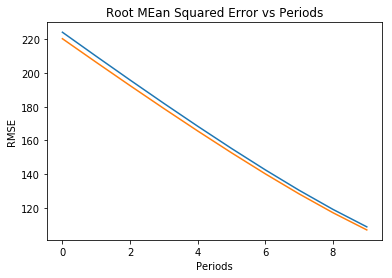

In [42]:
minimal_features = ["median_income", "lat_to_33", 
                    "lat_33_to_34",
                    "lat_34_to_35",
                    "lat_35_to_36",
                    "lat_36_to_37",
                    "lat_37_to_38",
                    "lat_38_to_39",
                    "lat_39_to_40",
                    "lat_40_to_41",
                    "lat_41_to_42",
                   ]
assert minimal_features, "You must select at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

train_model(
    learning_rate=0.1,
    steps=500,
    batch_size=100,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets
)

This is weird, google answer is 'median_income' and latitude, but I have chose 'median_income' and 'rooms_per_person' and with 0.5 learning rate and bigger batch size I got much better results, i.e. RMSE of 86!


## Task 2: Make Better Use of Latitude

Plotting latitude vs median_house_value shows that there ins't a linear relationship


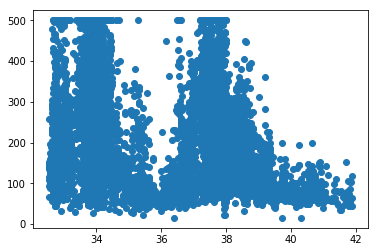

In [16]:
plt.scatter(training_examples["latitude"], training_targets["median_house_value"])

In [48]:
playground = training_examples.copy()
playground["lat_to_33"] = np.where(playground["latitude"] < 33, 1, 0)
playground["lat_33_to_34"] = np.where((playground["latitude"] >= 33)  & (playground["latitude"] < 34), 1, 0)
playground["lat_34_to_35"] = np.where((playground["latitude"] >= 34)  & (playground["latitude"] < 35), 1, 0)
playground["lat_35_to_36"] = np.where((playground["latitude"] >= 35)  & (playground["latitude"] < 36), 1, 0)
playground["lat_36_to_37"] = np.where((playground["latitude"] >= 36)  & (playground["latitude"] < 37), 1, 0)
playground["lat_37_to_38"] = np.where((playground["latitude"] >= 37)  & (playground["latitude"] < 38), 1, 0)
playground["lat_38_to_39"] = np.where((playground["latitude"] >= 38)  & (playground["latitude"] < 39), 1, 0)
playground["lat_39_to_40"] = np.where((playground["latitude"] >= 39)  & (playground["latitude"] < 40), 1, 0)
playground["lat_40_to_41"] = np.where((playground["latitude"] >= 40)  & (playground["latitude"] < 41), 1, 0)
playground["lat_41_to_42"] = np.where((playground["latitude"] >= 41)  & (playground["latitude"] < 42), 1, 0)
playground.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,lat_to_33,lat_33_to_34,lat_34_to_35,lat_35_to_36,lat_36_to_37,lat_37_to_38,lat_38_to_39,lat_39_to_40,lat_40_to_41,lat_41_to_42
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2669.7,541.9,1435.4,503.9,3.9,2.0,0.1,0.2,0.2,0.0,0.1,0.2,0.1,0.0,0.0,0.0
std,2.1,2.0,12.6,2217.2,423.3,1162.6,388.6,1.9,1.3,0.2,0.4,0.4,0.2,0.2,0.4,0.3,0.2,0.1,0.1
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,33.9,-121.8,18.0,1465.0,296.0,789.0,281.0,2.6,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,34.2,-118.5,29.0,2146.5,434.0,1167.5,410.0,3.6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,37.7,-118.0,37.0,3180.2,652.0,1726.0,608.0,4.8,2.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,42.0,-114.6,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


My solution was producing better results by virtue of higher learning rate and batch size.

In [ ]:


def select_and_transform_features(source_df):
  LATITUDE_RANGES = zip(range(32, 44), range(33, 45))
  selected_examples = pd.DataFrame()
  selected_examples["median_income"] = source_df["median_income"]
  for r in LATITUDE_RANGES:
    selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
      lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
  return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)


Training model...
RMSE (on training data:)
   period: 00 : 237.37
   period: 01 : 235.99
   period: 02 : 234.62
   period: 03 : 233.25
   period: 04 : 231.88
   period: 05 : 230.51
   period: 06 : 229.15
   period: 07 : 227.78
   period: 08 : 226.42
   period: 09 : 225.05
Model training finished.


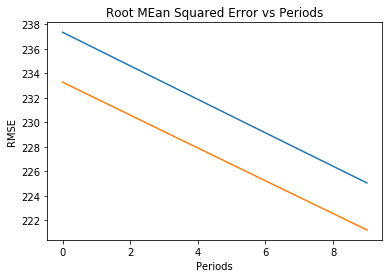

In [45]:
_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)